In [13]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import expm
from copy import deepcopy
import xgboost as xgb
import time
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc, precision_score, recall_score
import seaborn as sns

In [2]:
# model = xgb.XGBClassifier(objective = 'binary:logistic', 
#                         seed=42, 
#                         n_estimators=230,
#                         eval_metric='aucpr',
#                         n_jobs = -1)

# model.load_model("xgboost_sim_full.json")

In [3]:
# results = model.evals_result()

In [17]:
df = pd.read_csv('./robotdatacollection3_part2/ep1.csv')
# df = pd.read_csv('./robot_data/ep4_new.csv')

# model = keras.models.load_model('./sim_final_full')
model = keras.models.load_model('./Thesis/thesis2_classifier')

# model = keras.models.load_model('./robot_1_full')
robot_flag=True

threshold = 0.5

In [18]:
ERROR_TOP = 0.0008
PEG_RADIUS = 0.0021
HOLE_RADIUS = 0.0024

MEMORY_LEN = 100
FEATURE_SIZE = 5
cnt = 0
robot = True

In [19]:
memory = [[0] * FEATURE_SIZE for _ in range(MEMORY_LEN)]
pred_num = 5
pred_memory = [0 for _ in range(pred_num)]

In [20]:
feature_names = ['Fx', 'Fy', 'Fz', 'Mx', 'My']
# feature_names = ['fz']
# 
# feature_names = ['fx', 'fy', 'fz', 'mx', 'my']

X_df = df[feature_names]
y = df.Case.to_numpy()

# moving average
# roll = 30
# X_df = X_df.rolling(roll).mean()
# X_df = X_df.loc[roll-1:]
# y = y[roll-1:]


X = X_df.to_numpy()

window_len = 100#300

if window_len:
    n_features = len(feature_names)  # 3

    row = X.shape[0] + 1 - window_len
    col_len = n_features * window_len
    new_x = np.zeros((row, col_len))
    new_y = np.zeros((row, 1))

    for i in range(len(new_x)):
        new_x[i] = X[i:i + window_len].reshape(1, col_len)[0][::-1]
        new_y[i] = y[i + (window_len - 1)]

    y = deepcopy(new_y)
    X = deepcopy(new_x)

total = len(y)
pos = int(y.sum())
neg = total - pos
weight = neg/pos # 13.5

In [21]:
y_test_pred = model.predict(X)

170/170 [==============================] - 0s 1ms/step


In [22]:
def fancy_confusion(cf_matrix, title):
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    plt.title(title)
    sns.heatmap(cf_matrix, annot=labels,cmap='YlOrRd',fmt="")
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

In [23]:
print("Perfect confusion matrix")
print(confusion_matrix(y, y > 0.5))

Perfect confusion matrix
[[5310    0]
 [   0  125]]


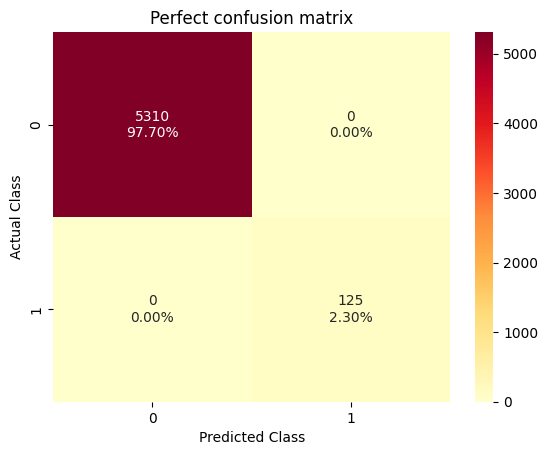

In [24]:
fancy_confusion(confusion_matrix(y, y > 0.5),"Perfect confusion matrix" )

In [25]:
print(confusion_matrix(y, y_test_pred > 0.5))

[[5302    8]
 [ 125    0]]


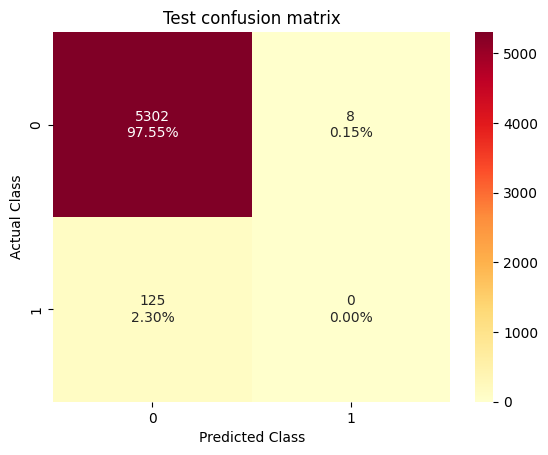

In [26]:
fancy_confusion(confusion_matrix(y, y_test_pred > 0.5),"Test confusion matrix" )

### Stream sensor measuerements and let it predict - sensor measurements are already after contact!


In [25]:
def append_vector(array, vector):
    # Discard the oldest value
    array.pop()
    # Add the new value
    array.insert(0, vector)

In [ ]:
 def circle_check(peg_x,peg_y,robot):
        # CHANGE FOR SIM AND ROBOT
        if robot:
            hole_x = -0.1379
            hole_y = -0.5095
        else:
            hole_x = 0
            hole_y = 0

        print(np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2))
        
        if np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2) < ERROR_TOP:
            return True
        else:
            return False


In [ ]:
df.columns

In [ ]:
x = df.x.values
y = df.y.values
z = df.z.values
# fx = df.fx.values
# fy = df.fy.values
# fz = df.fz.values
# mx = df.mx.values
# my = df.my.values
# mz = df.mz.values
# case = df.case.values

fx = df.Fx.values
fy = df.Fy.values
fz = df.Fz.values
mx = df.Mx.values
my = df.My.values
mz = df.Mz.values
case = df.Case.values

In [ ]:
start_idx = df.index[df['Case'].diff() == 1].tolist()
print(start_idx)
print(df.loc[start_idx[0]].t)
print(df.loc[start_idx[1]].t)
# print(df.loc[start_idx[2]].t)

In [ ]:
# DNN
vnt=0
switch = False
cnt_list = []
while cnt < len(df):
    # fx,fy,fz,mx,my
    
    features = np.array([fx[cnt],fy[cnt],fz[cnt],mx[cnt],my[cnt]])
    rev_features = features[::-1]  # reverse to match inputs for training NN
    features_list = rev_features.tolist()
    
    append_vector(memory, features_list)
    # we need to fill out the buffer else it's filled with zeros
    if cnt >= MEMORY_LEN:
        X_vec = np.array(memory).reshape(1, MEMORY_LEN*FEATURE_SIZE)
#         print(X_vec.shape)
        t_init=time.time()
        y_predict = model(X_vec)
        print('PRED_TIME',time.time()-t_init)
        temp_overlap = (y_predict >= threshold)
        
        print('prediction', y_predict)
        inst_overlap = temp_overlap.numpy()[0][0]  # boolean true/false conversion tensor->bool
        print('Model detected overlap', inst_overlap)
        print('Geometric overlap', circle_check(df.x.values[cnt],df.y.values[cnt],robot=robot_flag))
        print('Time', df.t.values[cnt])
        print(cnt)
        print()
        append_vector(pred_memory, inst_overlap)
        if all(pred_memory):
            print('SWITCH!!!!')
            switch = True
            cnt_list.append(cnt)
#             cnt = len(df)-1
    cnt += 1

In [ ]:
one_occurace = np.where(df.Case == 1)[0]
print(one_occurace)

In [ ]:
cnt_list

In [ ]:
def plot_with_labels(df, name, show_label):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    if show_label:
        for i in cnt_list:
            plt.scatter(df.t.loc[i], df[name].loc[i],marker='*', color='red', zorder=12, alpha=0.2)
    
    plt.grid()
    plt.show()

def plot_vs_time(df, name):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    plt.grid()
    plt.show()

In [ ]:
for f in feature_names:
    plot_with_labels(df=df,name=f,show_label=True)
    

In [ ]:
# # XGB

# switch = False
# while cnt < len(df):
#     # fx,fy,fz,mx,my
    
#     features = np.array([fx[cnt],fy[cnt],fz[cnt],mx[cnt],my[cnt]])
#     rev_features = features[::-1]  # reverse to match inputs for training NN
#     features_list = rev_features.tolist()
# #     print(cnt)
#     append_vector(memory, features_list)
#     # we need to fill out the buffer else it's filled with zeros
#     if cnt >= MEMORY_LEN:
#         X_vec = np.array(memory).reshape(1, MEMORY_LEN*FEATURE_SIZE)
# #         print(X_vec)
# #         t_temp = time.time()
#         y_predict = model.predict_proba(X_vec)[:, 1][0]
# #         print(time.time()-t_temp)
#         temp_overlap = (y_predict >= threshold)
        
#         print('prediction', y_predict)
#         print('Model detected overlap', temp_overlap)
#         print('Geometric overlap', circle_check(df.x.values[cnt],df.y.values[cnt], robot=robot_flag))
#         print('Time', df.t.values[cnt])
#         print()
# #         print(pred_memory)
#         append_vector(pred_memory, temp_overlap)
#         if all(pred_memory):
#             print('SWITCH!!!!')
#             switch = True
            
#             cnt = len(df)-1
#     cnt += 1

In [ ]:
start_idx = df.index[df['Case'].diff() == 1].tolist()
print(start_idx)
print(df.loc[start_idx[0]].t)
print(df.loc[start_idx[1]].t)
# print(df.loc[start_idx[2]].t)

In [ ]:
plt.figure()
plt.scatter(df.t.values, df.Case.values)
plt.grid()
plt.title('Case')
plt.show()

plt.figure()
plt.plot(df.t.values, df.Fx.values)
plt.grid()
plt.title('Fx')
plt.show()

plt.figure()
plt.plot(df.t.values, df.Fy.values)
plt.grid()
plt.title('Fy')
plt.show()

plt.figure()
plt.plot(df.t.values, df.Fz.values)
plt.grid()
plt.title('Fz')
plt.show()





In [ ]:
temp_vec = np.where(df.Case == 1)
for x in temp_vec:
    print(x)


In [ ]:
df.loc[17585].t-df.loc[17229].t

In [ ]:
a = pd.DataFrame([0,0,0,0,0,1,1,1,0,0,0,1,1,0,0],columns=['Case'])

In [ ]:
a

In [ ]:
start_idx = a.index[a['Case'].diff() == 1].tolist()
stop_idx = a.index[a['Case'].diff() == -1].tolist()

In [ ]:
start_idx

In [ ]:
stop_idx

In [ ]:
a.loc[0:0]

In [ ]:
new_df = a.iloc[start_idx[0]:stop_idx[0]]

In [ ]:
new_df